In [1]:
from interaction_inference import dataset, optimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Interaction Prior: miRNA Targets

### Prior over gene pairs

Given a large dataset of RNA samples, the number of possible pairs to test for interaction grows quickly and it seems impractical to test them all. We would like a **prior** over pairs that can help identify those more likely to be interacting and so reduce computation.

### TargetScan miRNA targets

Micro RNA (miRNA) are small non-coding RNA that play an important role in regulating expression by splitting / degrading certain mRNA transcripts (and sometimes affecting translation). [**TargetScan**](https://www.targetscan.org/vert_80/) is a database that predicts the mRNA targetted by a given miRNA, providing a set of candidate (miRNA, mRNA) pairs to test for interaction using our methods: these targets can be used as a prior (reducing the computational load), or as validation (testing if results match the biology).

### Accuracy

However, we need to test the accuracy (or other metrics) of the predicted targets: TargetScan warns that many predictions are false positives. Also, these are only predictions of **possible** interactions between genes, whether they are interacting in the experiment where the data was collected depends on many factors.

## Dataset: RNA types

For the Smart-seq-total dataset of transcript counts in human fibroblast cells we lookup (*) the type of each RNA and use this to select the samples of miRNA and protein coding mRNA.

We see there are 18 miRNA and 9376 protein coding mRNA present in the dataset (**)

___

(*) API used sometimes fails to retrieve information, may be because gene name in the dataset doesn't match a record in the Ensembl database, or may be outdated / other issues

(**) API is slow so only have types for genes with mean expression > 1

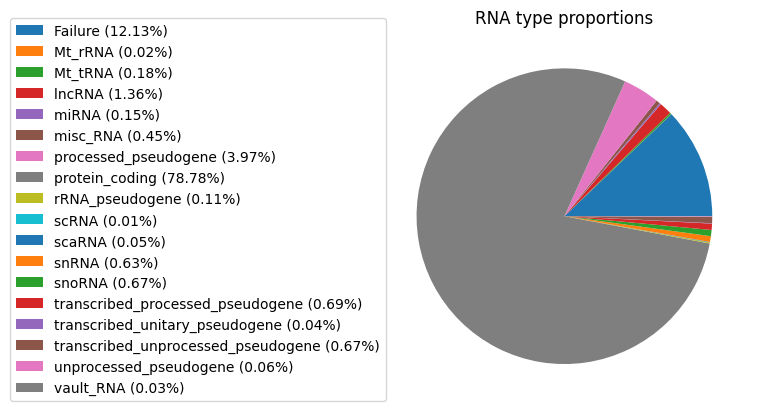

18 miRNA 
9376 protein coding mRNA


,Fibroblasts_A10_S10,Fibroblasts_A11_S11,Fibroblasts_A2_S2,Fibroblasts_A3_S3,Fibroblasts_A4_S4,Fibroblasts_A5_S5,Fibroblasts_A7_S7,Fibroblasts_A8_S8,Fibroblasts_B10_S34,Fibroblasts_B11_S35,...,Fibroblasts_P18_S378,Fibroblasts_P1_S361,Fibroblasts_P21_S381,Fibroblasts_P22_S382,Fibroblasts_P23_S383,Fibroblasts_P3_S363,Fibroblasts_P4_S364,Fibroblasts_P5_S365,Fibroblasts_P6_S366,Fibroblasts_P8_S368
MIR100,0,5,0,0,1,0,0,0,0,2,...,3,0,4,2,105,0,0,0,0,0
MIR103A2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62
MIR16-2,0,0,0,0,0,0,0,0,0,0,...,66,0,10,3,39,0,29,0,0,0
MIR199A1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
MIR199A2,1,0,1,0,0,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
MIR221,19,0,0,0,13,0,0,0,0,0,...,0,0,0,0,51,0,2,0,0,0
MIR222,37,16,1,7,18,3,1,25,15,19,...,44,5,39,8,43,1,3,2,6,2
MIR23A,0,7,0,0,2,0,0,4,0,1,...,10,0,6,0,437,0,1,0,3,1
MIR24-2,0,2,0,0,0,0,0,0,2,0,...,3,0,12,12,28,0,0,1,1,0
MIR27A,0,5,0,0,6,2,6,10,3,1,...,0,0,1,0,0,0,0,0,1,0


In [416]:
# read fibroblast transcript counts (for all genes)
data_all_FIB = pd.read_csv("../Datasets/GSE151334_FIB_counts_cleaned.csv", index_col=0)

# read fibroblast transcript counts (for genes with mean expression > 1)
data_FIB = pd.read_csv("../Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

# read RNA types in from file
biotypes_dict = json.load(open("../Datasets/GSE151334_RNA_types_thresh.json"))
biotypes_dict = {int(i): btype for i, btype in biotypes_dict.items()}
biotypes = [btype for btype in biotypes_dict.values()]

# display proportions of RNA types
counts = np.unique(biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(-1, 0), labels=[f"{name} ({round(100 * count / data_FIB.shape[0], 2)}%)" for name, count in zip(counts[0], counts[1])])
plt.title("RNA type proportions")
plt.show()

# select indices of types
pcRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "protein_coding"]
miRNA_indices = [idx for idx, val in enumerate(biotypes) if val == "miRNA"]

# select rows by index
data_pcRNA = data_FIB.iloc[pcRNA_indices]
data_miRNA = data_FIB.iloc[miRNA_indices]

print(f"{data_miRNA.shape[0]} miRNA \n{data_pcRNA.shape[0]} protein coding mRNA")

data_miRNA

# Inference

To investigate the TargetScan predictions we will take each miRNA and pair it with every protein coding mRNA in the dataset, using the 'moment independence-feasiiblity test' (feasibility of $ E[X1X2] = E[X1] E[X2] $ for moments of each sample) to determine if the pair seems to be interacting or independent given the data.

## Code setup

### Estimate capture efficiency

Using single cell RNA sequencing data means the transcript counts are affected by significant capture efficiency. This is important to account for and so we estimate the per cell capture efficiency with an approach used by **BayNorm**, normalizing the total counts per cell to a set mean value (discounting outlying genes).

Capture efficiency is assumed to vary per cell, but not per gene, so estimation is done once using the entire dataset (all RNA) and does not need to be repeated.

In [375]:
def estimate_capture(df, beta_mean=0.1):

    # set mean beta
    MeanBETA = beta_mean

    #xx<-Matrix::colSums(Data)
    xx = df.sum(axis='rows')

    #Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
    # Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
    Normcount = (df / xx) * np.mean(xx) # sum = mean(xx) per column

    #means <- Matrix::rowMeans(Normcount)
    means = Normcount.mean(axis='columns')

    #lmeans <- log(means)
    lmean = np.log(means)

    #med <- apply(log(Normcount + 1), 1, function(x) {
    #    median(x)
    #})
    med = np.log(Normcount + 1).median(axis=1)

    #mad <- apply(log(Normcount + 1), 1, function(x) {
    #    mad(x)
    #})
    mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

    #bound <- med + 3 * mad
    bound = med + 3*mad

    #maxlogGene <- apply(log(Normcount + 1), 1, max)
    maxlogGene = np.log(Normcount + 1).max(axis=1)

    #ind <- which(maxlogGene < bound)
    ind = maxlogGene < bound

    #dropout = apply(Data, 1, function(x) {
    #    length(which(x == 0))/length(x)
    #})
    dropout = df.apply(lambda row: (row == 0).sum() / row.size, axis=1)


    #Select_ind <- intersect(ind, which(dropout < 0.35))
    Select_ind = ind & (dropout < 0.35)

    # Selected_genes <- rownames(Data)[Select_ind]
    Selected_genes = list(Select_ind.index)

    #temppp <- Matrix::colSums(Data[Select_ind, ])
    temppp = df[Select_ind].sum(axis=0)

    #BETA <- temppp/mean(temppp) * MeanBETA
    BETA = (temppp / temppp.mean()) * MeanBETA

    #if (length(which(BETA >= 1)) > 0) {
    #    BETA[BETA >= 1] = max(BETA[BETA < 1])
    #}
    #if (length(which(BETA <= 0)) > 0) {
    #    BETA[BETA <= 0] = min(BETA[BETA > 0])
    #}
    if (BETA >= 1).size > 0:
        BETA[BETA >= 1] = BETA[BETA < 1].max()
    if (BETA <= 0).size > 0:
        BETA[BETA <= 0] = BETA[BETA > 0].min()

    #names(BETA) <- colnames(Data)

    #return(list(BETA = BETA, Selected_genes = Selected_genes))
    BETA = BETA.to_numpy()
    
    return BETA

In [417]:
beta = estimate_capture(data_FIB)
beta_all = estimate_capture(data_all_FIB)

### Constructing dataset

For a chosen miRNA and its predicted mRNA targets, alongside inference settings, we construct a dataset of (miRNA, mRNA) pairs to run through a feasiblity test

In [377]:
def construct_dataset(name, mir_sample, target_samples, beta, thresh_OB=5, resamples=1000):

    # size
    gene_pairs, cells = target_samples.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mir_sample
        gene_j = target_samples.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = dataset.Dataset(name)
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.thresh_OB = thresh_OB
    data.threshM_OB = thresh_OB
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

## Example: MIR103

Taking the second miRNA in the dataset MIR103A2, TargetScan predicts 4756 RNA as possible targets for interaction.

However, we only have data for 4419 of these as some genes had 0 counts observed e.g. may not have been expressed during the experiment (and only know types for the 2700 of these genes with mean expression > 1). The majority of targets (m.e. > 1) are known to be protein coding mRNA, with the unprocessed + failed API lookups expected to be the same.

NOTE: add biotypes when found for expression < 1 genes

4756 miRNA targets predicted
4419 are in the dataset (mean expr > 0)
2770 are in the dataset (mean expr > 1)


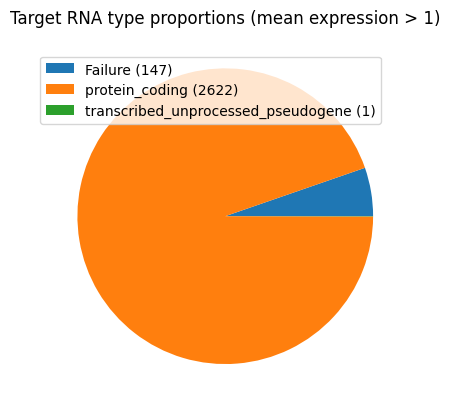

In [525]:
# load predicted targets
target_df = pd.read_csv("TargetScan8.0__miR-103a-2-5p.Human.predicted_targets.txt", delimiter="\t", index_col=0)

# display statistics
target_names = list(target_df.index)
gene_names_all = list(data_all_FIB.index)
gene_names_thresh = list(data_FIB.index)
shared_names_all = list(set(target_names) & set(gene_names_all))
shared_names_thresh = list(set(target_names) & set(gene_names_thresh))

print(f"{len(target_names)} miRNA targets predicted")
print(f"{len(shared_names_all)} are in the dataset (mean expr > 0)")
print(f"{len(shared_names_thresh)} are in the dataset (mean expr > 1)")

# target biotypes
target_biotypes = []
for i, btype in biotypes_dict.items():
    if gene_names_thresh[i] in target_names:
        target_biotypes.append(btype)

# display proportions of RNA types
counts = np.unique(target_biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(0,0.75), labels=[f"{name} ({count})" for name, count in zip(counts[0], counts[1])])
plt.title("Target RNA type proportions (mean expression > 1)")
plt.show()

Construct dataset of (miRNA, mRNA) pairs and test feasibility of independence to detect interaction.

In [419]:
# construct dataset of the miRNA paired with all other samples
dataset_mir = construct_dataset("miRNA103a2", data_miRNA.loc["MIR103A2"], data_all_FIB, beta_all)

In [421]:
# bootstrap moments
dataset_mir.compute_moments(tqdm_disable=False)

100%|██████████| 34800/34800 [09:24<00:00, 61.61it/s]


In [422]:
# moment optimization test
moment_mir = optimization.Optimization(
    dataset_mir,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file=None
)

100%|██████████| 34800/34800 [01:25<00:00, 406.96it/s]


Construct a dataset of results, for each (miRNA, mRNA) pair record:

- if mRNA is a predicted target
- TargetScan prediction score
- result of feasibility test
- mean expression level

In [428]:
# create result dataframe
result_df = pd.DataFrame(
    index = data_all_FIB.index,
    columns = ['Target', 'Score', 'Interaction', 'Expression']
)

# enter results
for i, result in moment_mir.result_dict.items():

    # get gene name
    name = gene_names_all[i]

    # if miRNA target: get prediction score
    if name in target_names:
        target = True
        score = target_df.loc[name]['Cumulative weighted context++ score']
    else:
        target = False
        score = None

    # get interaction prediction
    if result['status'] == "INFEASIBLE":
        interaction = True
    else:
        interaction = False

    # get mean expression level
    mean_expression = float(data_all_FIB.loc[name].mean())

    result_df.iloc[i] = [target, score, interaction, mean_expression]

In [529]:
tg = result_df[result_df['Target'] == True]['Interaction']
ntg = result_df[result_df['Target'] == False]['Interaction']

print(f"Target genes have {tg.mean() * 100}% interaction detected")
print(f"Non-Target genes have {ntg.mean() * 100}% interaction detected")

Target genes have 15.048653541525232% interaction detected
Non-Target genes have 14.06800302820842% interaction detected


Text(0.5, 1.0, 'miRNA target genes: prediction score vs interaction detection')

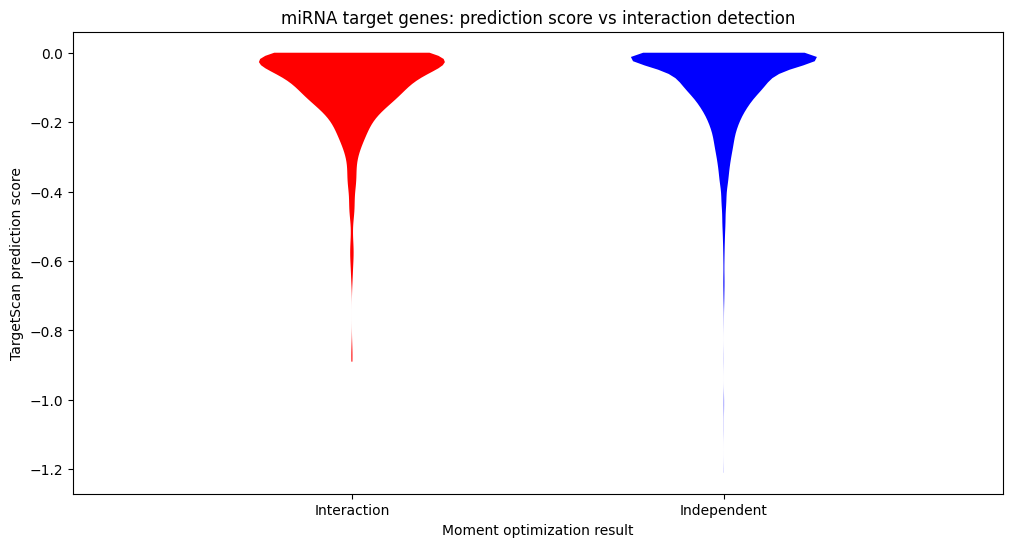

In [530]:
df = result_df[result_df['Target'] == True]
pos = df[df['Interaction'] == True]['Score'].to_list()
neg = df[df['Interaction'] == False]['Score'].to_list()

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan prediction score")
axs.set_title("miRNA target genes: prediction score vs interaction detection")

Text(0.5, 1.0, 'miRNA target genes: mean expression vs interaction detection')

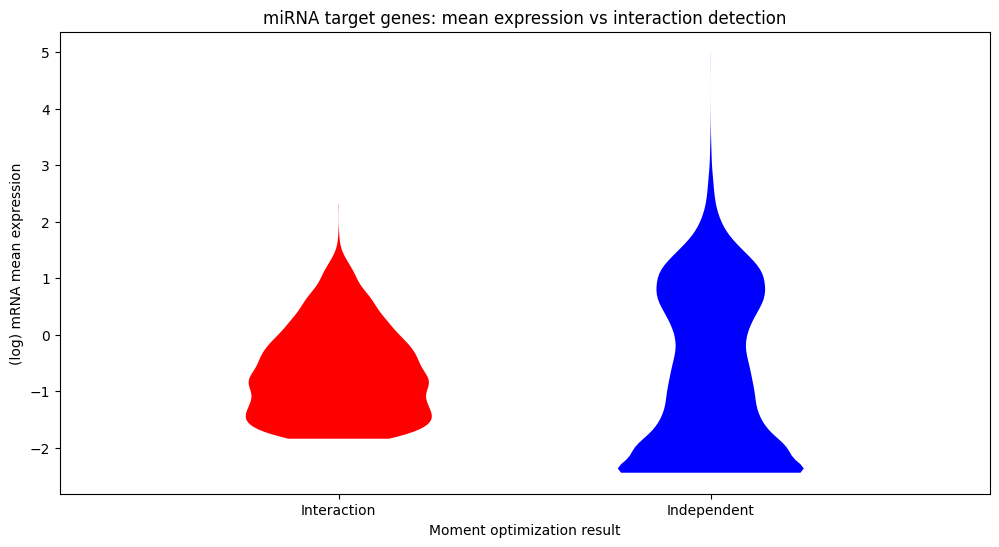

In [531]:
# separate by interaction / independent result
int_df = result_df[result_df['Interaction'] == True]
ind_df = result_df[result_df['Interaction'] == False]

# get log mean expression
int_means = np.log10(int_df['Expression'].to_list())
ind_means = np.log10(ind_df['Expression'].to_list())

# plot
fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        int_means,
        ind_means
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("(log) mRNA mean expression")
axs.set_title("miRNA target genes: mean expression vs interaction detection")

### Results

Separating (miRNA, mRNA) pairs by target vs non-target, the proportion of interacting pairs is roughly equal with the non-target slightly lower at 14% vs 15%. This suggests that the predicted targets do not match very closely with the actual interaction within the data, although this is expected as there is much variation and genes that can interact do not neccessarily always do.

Separating target pairs by interaction detection and looking at TargetScan prediction score, there does not seem to be any difference in distribution of score for interacting vs independent pairs.

Separating all pairs by independence vs interaction detection and looking at the mean expression level of the mRNA, there is a difference in distribution for the 2 categories: interacting genes are concentrated around lower expression, suggesting they are being heavily down-regulated by the miRNA (makes sense with the biological context of miRNA degrading mRNA), whereas interacting genes have a wider distribution including higher levels.

**However**, there is a sudden cutoff in the minimum expression level of interacting genes: this could be real, or it may be that at such low expression levels e.g. $10^{-2}$ the moment method is not able to detect interaction as well.

## Full Dataset analysis

Setup pipeline to follow the inference process above for each miRNA, producing a dataset of results where each gene records: target (bool), prediction score (float), interaction (bool), mean expression (float)

### Code Setup

In [500]:
def target_analysis(miRNA_name, target_file):

    # load predicted targets
    target_df = pd.read_csv(target_file, delimiter="\t", index_col=0)

    # get gene names
    target_names = list(target_df.index)
    gene_names_all = list(data_all_FIB.index)
    gene_names_thresh = list(data_FIB.index)
    shared_names_all = list(set(target_names) & set(gene_names_all))
    shared_names_thresh = list(set(target_names) & set(gene_names_thresh))

    # display statistics
    print(f"{len(target_names)} miRNA targets predicted")
    print(f"{len(shared_names_all)} are in the dataset (mean expr > 0)")
    print(f"{len(shared_names_thresh)} are in the dataset (mean expr > 1)")

    # construct dataset of the miRNA paired with all other samples
    dataset_mir = construct_dataset("miRNA103a2", data_miRNA.loc[miRNA_name], data_all_FIB, beta_all)

    # bootstrap moments
    dataset_mir.compute_moments(tqdm_disable=False)

    # moment optimization test
    moment_mir = optimization.Optimization(
        dataset_mir,
        [
            "dummy_moment"
        ],
        tqdm_disable=False,
        print_solution=False,
        license_file=None
    )

    # create result dataframe
    result_df = pd.DataFrame(
        index = data_all_FIB.index,
        columns = ['Target', 'Score', 'Interaction', 'Expression']
    )

    # enter results
    for i, result in moment_mir.result_dict.items():

        # get gene name
        name = gene_names_all[i]

        # if miRNA target: get prediction score
        if name in target_names:
            target = True
            score = target_df.loc[name]['Cumulative weighted context++ score']
            # protection against duplicate names
            if type(score) == pd.core.series.Series:
                score = score.iloc[0]
        else:
            target = False
            score = None

        # get interaction prediction
        if result['status'] == "INFEASIBLE":
            interaction = True
        else:
            interaction = False

        # get mean expression level
        mean_expression = float(data_all_FIB.loc[name].mean())

        result_df.iloc[i] = [target, score, interaction, mean_expression]

    return result_df

### Select miRNA targets

For an miRNA in the dataset use TargetScan to get the predicted mRNA targets

In [ ]:
target_files = [
    [
        "TargetScan8.0__miR-100-3p.Human.predicted_targets.txt",
        "TargetScan8.0__miR-99-5p_100-5p.Human.predicted_targets.txt"
    ],
    ["TargetScan8.0__miR-103a-2-5p.Human.predicted_targets.txt"],
    ["TargetScan8.0__miR-16-2-3p_195-3p.Human.predicted_targets.txt"],
    []
]

### Running

#### MIR100

In [ ]:
# details
miRNA = "MIR100"
target_file = "TargetScan8.0__miR-100-3p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR100_TargetScan8.0__miR-100-3p.Human.predicted_targets.csv")

3181 miRNA targets predicted
2989 are in the dataset (mean expr > 0)
2016 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:24<00:00, 409.97it/s]


In [ ]:
# details
miRNA = "MIR100"
target_file = "TargetScan8.0__miR-99-5p_100-5p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR100_TargetScan8.0__miR-99-5p_100-5p.Human.predicted_targets.csv")

369 miRNA targets predicted
348 are in the dataset (mean expr > 0)
224 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:26<00:00, 404.65it/s]


#### MIR103A2

In [ ]:
# details
miRNA = "MIR103A2"
target_file = "TargetScan8.0__miR-103a-2-5p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR103A2_TargetScan8.0__miR-103a-2-5p.Human.predicted_targets.csv")

4756 miRNA targets predicted
4419 are in the dataset (mean expr > 0)
2770 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:26<00:00, 404.38it/s]


#### MIR16-2

In [ ]:
# details
miRNA = "MIR16-2"
target_file = "TargetScan8.0__miR-16-2-3p_195-3p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR16-2_TargetScan8.0__miR-16-2-3p_195-3p.Human.predicted_targets.csv")

4485 miRNA targets predicted
4201 are in the dataset (mean expr > 0)
2807 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:30<00:00, 383.10it/s]


#### MIR199A1

In [449]:
# details
miRNA = "MIR199A1"
target_file = "TargetScan8.0__miR-199-3p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR199A1_TargetScan8.0__miR-199-3p.Human.predicted_targets.csv")

3015 miRNA targets predicted
2832 are in the dataset (mean expr > 0)
1920 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:27<00:00, 398.43it/s]


In [ ]:
# details
miRNA = "MIR199A1"
target_file = "TargetScan8.0__miR-199-5p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR199A1_TargetScan8.0__miR-199-5p.Human.predicted_targets.csv") <<<

4210 miRNA targets predicted
3919 are in the dataset (mean expr > 0)
2470 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:28<00:00, 393.94it/s]


#### MIR199A2

In [451]:
# details
miRNA = "MIR199A2"
target_file = "TargetScan8.0__miR-199-3p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR199A2_TargetScan8.0__miR-199-3p.Human.predicted_targets.csv")

3015 miRNA targets predicted
2832 are in the dataset (mean expr > 0)
1920 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:23<00:00, 417.31it/s]


In [501]:
# details
miRNA = "MIR199A2"
target_file = "TargetScan8.0__miR-199-5p.Human.predicted_targets.txt"

# analysis
result_df = target_analysis(miRNA, target_file)

# store
result_df.to_csv("Results/MIR199A2_TargetScan8.0__miR-199-5p.Human.predicted_targets.csv")

4210 miRNA targets predicted
3919 are in the dataset (mean expr > 0)
2470 are in the dataset (mean expr > 1)


100%|██████████| 34800/34800 [01:31<00:00, 379.05it/s]


### Result analysis

In [453]:
def interaction_percentages(result_df):
    '''Display % interaction detection for target vs non-target genes.'''

    tg = result_df[result_df['Target'] == True]['Interaction']
    ntg = result_df[result_df['Target'] == False]['Interaction']

    print(f"Target genes have {tg.mean() * 100}% interaction detected")
    print(f"Non-Target genes have {ntg.mean() * 100}% interaction detected")

In [470]:
def prediction_score_distribution(result_df, miRNA_name="miRNA"):
    '''Display score distribution for interacting vs independent target genes.'''

    df = result_df[result_df['Target'] == True]
    pos = df[df['Interaction'] == True]['Score'].to_list()
    neg = df[df['Interaction'] == False]['Score'].to_list()

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        [
            pos,
            neg
        ],
        showextrema=False
    )
    colours = ["red", "blue"]
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor(colours[i])
        vi.set_edgecolor(None)
        vi.set_alpha(1)
    labels = ["Interaction", "Independent"]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel('Moment optimization result')
    axs.set_ylabel("TargetScan prediction score")
    axs.set_title(f"{miRNA_name} target genes: prediction score vs interaction detection")

In [456]:
def mean_expression_distribution(result_df, miRNA_name="miRNA"):
    '''Display mean expression distribution for interacting vs independent genes.'''

    # separate by interaction / independent result
    int_df = result_df[result_df['Interaction'] == True]
    ind_df = result_df[result_df['Interaction'] == False]

    # get log mean expression
    int_means = np.log10(int_df['Expression'].to_list())
    ind_means = np.log10(ind_df['Expression'].to_list())

    # plot
    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        [
            int_means,
            ind_means
        ],
        showextrema=False
    )
    colours = ["red", "blue"]
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor(colours[i])
        vi.set_edgecolor(None)
        vi.set_alpha(1)
    labels = ["Interaction", "Independent"]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel('Moment optimization result')
    axs.set_ylabel("(log) mRNA mean expression")
    axs.set_title(f"{miRNA_name} target genes: mean expression vs interaction detection")

In [623]:
def threshold_score_distribution(result_df, miRNA_name="miRNA"):

    mins = result_df['Score'].min()
    maxs = result_df['Score'].max()

    thresholds = [mins + (maxs - mins) * (x / 100) for x in range(100)]
    interation_prop = []

    for tau in thresholds:
        df = result_df[result_df['Score'] < tau]
        interation_prop.append(float(df['Interaction'].mean()) * 100)
                            
    plt.plot(thresholds, interation_prop)
    plt.xlabel("Score threshold")
    plt.ylabel("% Interaction")
    plt.title(f"{miRNA_name}: Interaction % for targets below Score threshold")

In [625]:
interaction_percentages(result_df)

Target genes have 7.910181168665476% interaction detected
Non-Target genes have 7.600142482432563% interaction detected


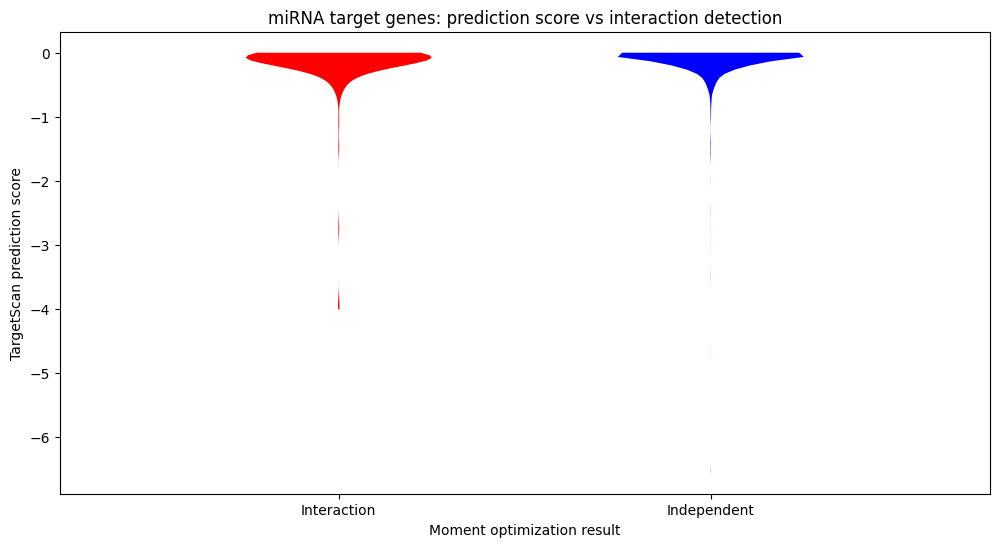

In [626]:
prediction_score_distribution(result_df)

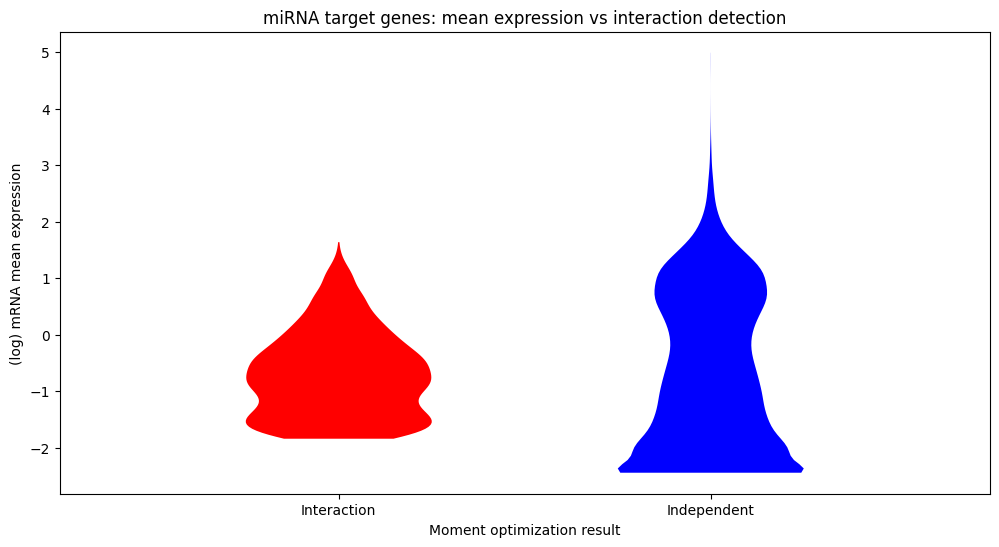

In [627]:
mean_expression_distribution(result_df)

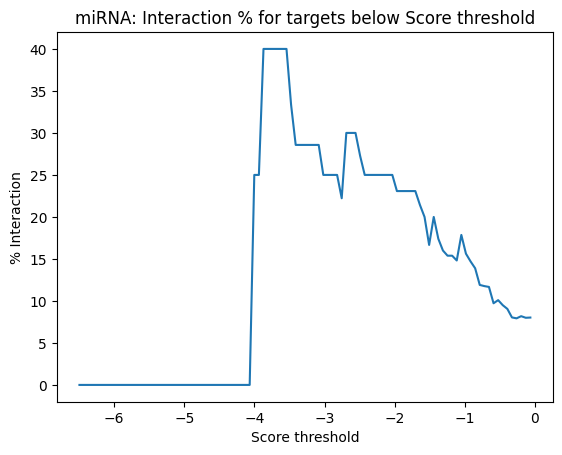

In [628]:
threshold_score_distribution(result_df)

# Investigating other scores

In [556]:
result_df = pd.read_csv("Results/MIR199A2_TargetScan8.0__miR-199-5p.Human.predicted_targets.csv", index_col=0)

In [557]:
target_df = pd.read_csv("TargetScan8.0__miR-199-5p.Human.predicted_targets.txt", delimiter="\t", index_col=0)
target_df.head()

,Representative transcript,Gene name,3P-seq tags + 5,Conserved sites total,Conserved 8mer sites,Conserved 7mer-m8 sites,Conserved 7mer-A1 sites,Poorly conserved sites total,Poorly conserved 8mer sites,Poorly conserved 7mer-m8 sites,Poorly conserved 7mer-A1 sites,6mer sites,Representative miRNA,Predicted occupancy (low miRNA),Predicted occupancy (high miRNA),Predicted occupancy (transfected miRNA),Cumulative weighted context++ score,Total context++ score,Aggregate PCT,Previous TargetScan publication(s)
Target gene,,,,,,,,,,,,,,,,,,,,
ZNF440,ENST00000304060.5,zinc finger protein 440,12,0,0,0,0,6,6,0,0,0,hsa-miR-199a-5p,0.0731,0.5037,2.5890,-6.56,-6.56,0.47,2011
ZNF844,ENST00000439326.3,zinc finger protein 844,11,0,0,0,0,6,4,2,0,0,hsa-miR-199b-5p,0.0484,0.3496,2.2352,-6.56,-6.56,0.36,2011
ZNF776,ENST00000317178.5,zinc finger protein 776,1447,1,1,0,0,6,3,2,1,0,hsa-miR-199a-5p,0.0750,0.5224,2.7911,-4.68,-4.68,0.68,"2009, 2011"
ZNF700,ENST00000482090.1,zinc finger protein 700,105,0,0,0,0,3,2,1,0,0,hsa-miR-199b-5p,0.0545,0.3738,1.9486,-4.01,-4.01,0.27,2009
ZNF419,ENST00000415379.2,zinc finger protein 419,42,0,0,0,0,3,3,0,0,0,hsa-miR-199a-5p,0.0462,0.3195,1.6949,-3.90,-3.90,< 0.1,2011


## Aggregate PCT

Text(0.5, 1.0, 'miRNA target genes: Aggregate PCT vs interaction detection')

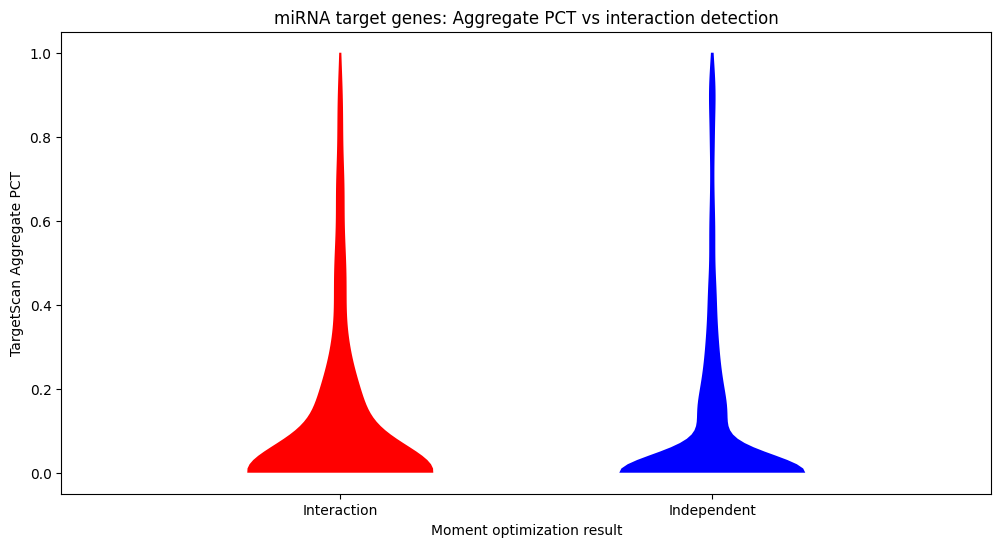

In [604]:
# get target genes
df = result_df[result_df['Target'] == True]

# get those interacting, and those independent
pos_ind = df[df['Interaction'] == True].index
neg_ind = df[df['Interaction'] == False].index

# get their PCT score
pos_raw = target_df.loc[pos_ind]['Aggregate PCT'].to_list()
neg_raw = target_df.loc[neg_ind]['Aggregate PCT'].to_list()

# adjust
pos = []
for x in pos_raw:
    if x == '< 0.1':
        pos.append(0)
    elif x == '> 0.99':
        pos.append(1)
    else:
        pos.append(float(x))
neg = []
for x in neg_raw:
    if x == '< 0.1':
        neg.append(0)
    elif x == '> 0.99':
        neg.append(1)
    else:
        neg.append(float(x))

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan Aggregate PCT")
axs.set_title(f"miRNA target genes: Aggregate PCT vs interaction detection")

## Cumulate weighted score (used in main analysis)

Text(0.5, 1.0, 'miRNA target genes: Cumulative weighted context++ score vs interaction detection')

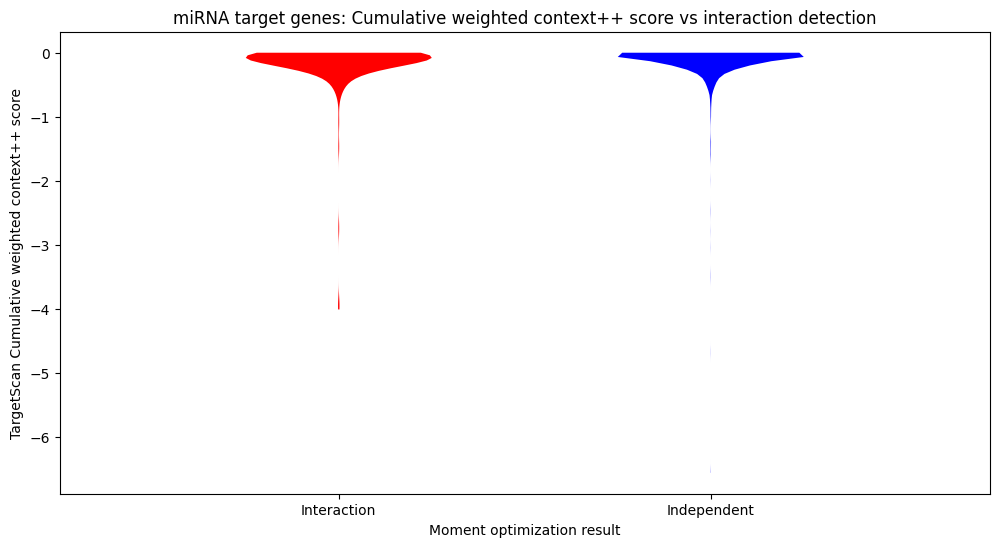

In [605]:
# get target genes
df = result_df[result_df['Target'] == True]

# get those interacting, and those independent
pos_ind = df[df['Interaction'] == True].index
neg_ind = df[df['Interaction'] == False].index

# get their PCT score
pos = target_df.loc[pos_ind]['Cumulative weighted context++ score'].to_list()
neg = target_df.loc[neg_ind]['Cumulative weighted context++ score'].to_list()

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan Cumulative weighted context++ score")
axs.set_title(f"miRNA target genes: Cumulative weighted context++ score vs interaction detection")

## Total score

Text(0.5, 1.0, 'miRNA target genes: Total context++ score vs interaction detection')

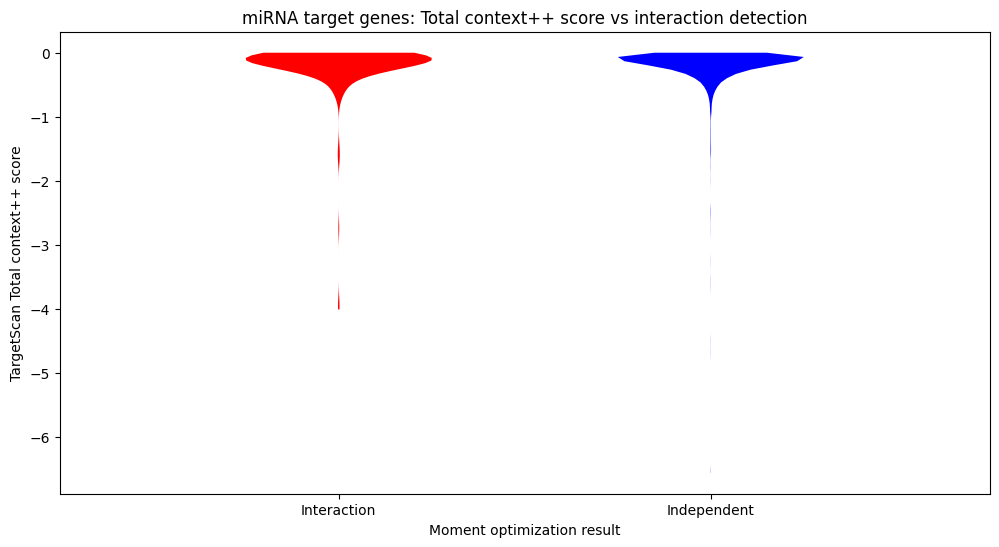

In [606]:
# get target genes
df = result_df[result_df['Target'] == True]

# get those interacting, and those independent
pos_ind = df[df['Interaction'] == True].index
neg_ind = df[df['Interaction'] == False].index

# get their PCT score
pos = target_df.loc[pos_ind]['Total context++ score'].to_list()
neg = target_df.loc[neg_ind]['Total context++ score'].to_list()

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan Total context++ score")
axs.set_title(f"miRNA target genes: Total context++ score vs interaction detection")

## Other

Any other numeric column in target dataframe: all provide roughly equal distributions for interacting vs independent targets

Text(0.5, 1.0, 'miRNA target genes: Predicted occupancy (transfected miRNA) vs interaction detection')

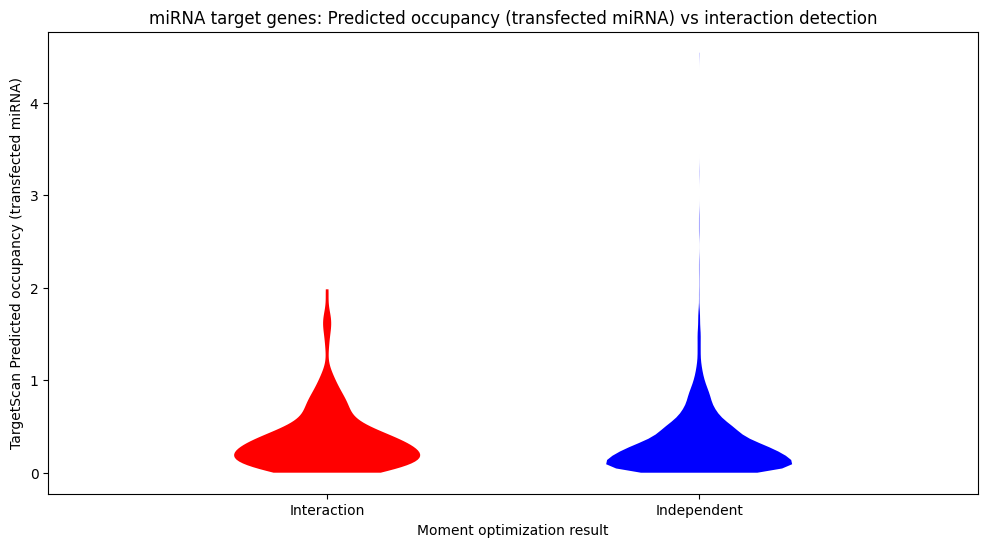

In [617]:
# column
col = 'Predicted occupancy (transfected miRNA)'

# get target genes
df = result_df[result_df['Target'] == True]

# get those interacting, and those independent
pos_ind = df[df['Interaction'] == True].index
neg_ind = df[df['Interaction'] == False].index

# get their PCT score
pos = target_df.loc[pos_ind][col].to_list()
neg = target_df.loc[neg_ind][col].to_list()

#pos = [np.log10(x) for x in pos if not x == 0]
#neg = [np.log10(x) for x in neg if not x == 0]

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel(f"TargetScan {col}")
axs.set_title(f"miRNA target genes: {col} vs interaction detection")

## Score threshold

% interaction detected in targets below a score threshold (lower score = higher confidence in prediction)

Text(0.5, 1.0, 'Interaction % for targets below Score threshold')

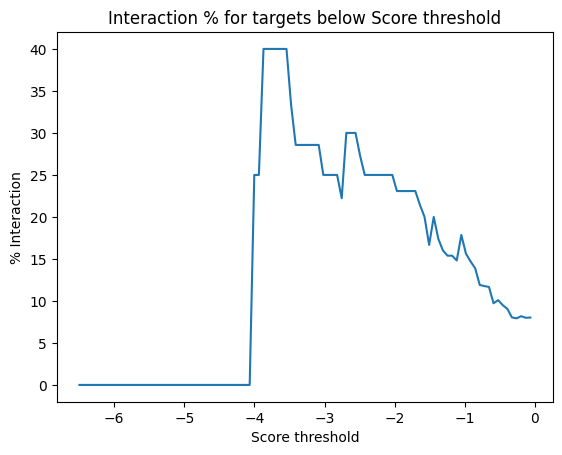

In [622]:
mins = result_df['Score'].min()
maxs = result_df['Score'].max()

thresholds = [mins + (maxs - mins) * (x / 100) for x in range(100)] #[-5 + x / 20 for x in range(100)]
interation_prop = []

for tau in thresholds:
    df = result_df[result_df['Score'] < tau]
    interation_prop.append(float(df['Interaction'].mean()) * 100)
                           
plt.plot(thresholds, interation_prop)
plt.xlabel("Score threshold")
plt.ylabel("% Interaction")
plt.title("Interaction % for targets below Score threshold")

# Mean expression vs Interaction detection

Plotting the distribution of mean mRNA expression levels for interacting vs independent (miRNA, mRNA) pairs we see that lower mean expression corresponds to a higher proportion of interaction, suggesting these mRNA are being heavily down regulated by the miRNA. **However**, at a certain expression level, ~$10^{-1.5}$, there are suddenly no pairs for which interaction is detected. This could be a reality e.g. these are just independent genes that are not being expressed, but the sudden dropoff raises concerns that the moment method may not be able to detect interaction below this expression level.

To test this we simulate interacting data where the interaction strength and one sample is fixed, but the other sample decreases its expression level and assess the results of moment optimization:

# Old code

4485 miRNA targets predicted
2807 are in the dataset


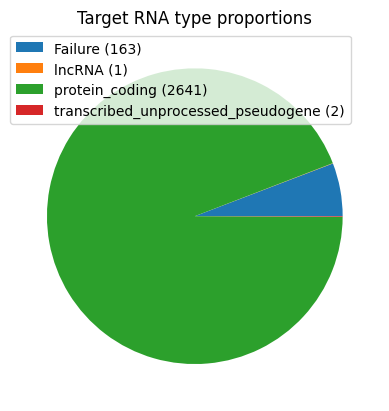

,Representative transcript,Gene name,3P-seq tags + 5,Total sites,8mer sites,7mer-m8 sites,7mer-A1 sites,6mer sites,Representative miRNA,Predicted occupancy (low miRNA),Predicted occupancy (high miRNA),Predicted occupancy (transfected miRNA),Cumulative weighted context++ score,Total context++ score,Aggregate PCT
Target gene,,,,,,,,,,,,,,,
CADM2,ENST00000383699.3,cell adhesion molecule 2,5,8,4,2,2,4,hsa-miR-16-2-3p,NaN,NaN,NaN,-1.11,-1.11,NaN
FUT9,ENST00000302103.5,"fucosyltransferase 9 (alpha (1,3) fucosyltrans...",5,3,0,1,2,1,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.92,-0.92,NaN
BCHE,ENST00000264381.3,butyrylcholinesterase,5,2,2,0,0,0,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.79,-0.79,NaN
AL353791.1,ENST00000426179.1,NaN,5,4,2,0,2,0,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.78,-0.78,NaN
RGS17,ENST00000367225.2,regulator of G-protein signaling 17,11,3,2,0,1,4,hsa-miR-16-2-3p,NaN,NaN,NaN,-0.76,-1.55,NaN


In [244]:
# set miRNA
mir = 2
i = 0

# load predicted targets
target_df = pd.read_csv(target_files[mir][i], delimiter="\t", index_col=0)

# display statistics
target_names = list(target_df.index)
gene_names = list(data_FIB.index)
shared_names = list(set(target_names) & set(gene_names))

print(f"{len(target_names)} miRNA targets predicted")
print(f"{len(shared_names)} are in the dataset")

# target biotypes
target_biotypes = []
for i, btype in biotypes_dict.items():
    if gene_names[i] in target_names:
        target_biotypes.append(btype)

# display proportions of RNA types
counts = np.unique(target_biotypes, return_counts=True)
plt.pie(counts[1])
plt.legend(loc=(0,0.75), labels=[f"{name} ({count})" for name, count in zip(counts[0], counts[1])])
plt.title("Target RNA type proportions")
plt.show()

target_df.head()

In [245]:
# construct dataset of the miRNA paired with all other samples
dataset_mir = construct_dataset("test", data_miRNA.iloc[mir], data_FIB, beta)

In [246]:
# bootstrap moments
dataset_mir.compute_moments(tqdm_disable=False)

100%|██████████| 11901/11901 [04:59<00:00, 39.68it/s]


In [247]:
# moment optimization test
moment_mir = optimization.Optimization(
    dataset_mir,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file=None
)

  0%|          | 0/11901 [00:00<?, ?it/s]

100%|██████████| 11901/11901 [00:43<00:00, 272.00it/s]


In [248]:
result_dict = {}

E_beta = np.mean(beta)
E_beta_sq = np.mean(beta**2)

for i, moment_dict in enumerate(dataset_mir.moments_OB.values()):
    x = moment_dict['E_x1']
    y = moment_dict['E_x2']
    z = moment_dict['E_x1_x2']

    lb = (x[0] / E_beta) * (y[0] / E_beta)
    ub = (x[1] / E_beta) * (y[1] / E_beta)

    # xy interval below z interval
    if (lb < (z[0] / E_beta_sq)) and (ub < (z[0] / E_beta_sq)):
        result_dict[i] = {'status': "INFEASIBLE"}
    # xy interval above z interval
    elif (lb > (z[1] / E_beta_sq)) and (ub > (z[1] / E_beta_sq)):
        result_dict[i] = {'status': "INFEASIBLE"}
    # xy interval overlaps with z interval
    else:
        result_dict[i] = {'status': "OPTIMAL"}

In [249]:
[res['status'] for res in moment_mir.result_dict.values()] == [res['status'] for res in result_dict.values()]

True

In [ ]:
# create result dataframe
result_df = pd.DataFrame(
    index = data_FIB.index,
    columns = ['Target', 'Score', 'Interaction']
)

# enter results
for i, result in moment_mir.result_dict.items():

    # get gene name
    name = gene_names[i]

    # if miRNA target: get prediction score
    if name in target_names:
        target = True
        score = target_df.loc[name]['Cumulative weighted context++ score']
    else:
        target = False
        score = None

    # get interaction prediction
    if result['status'] == "INFEASIBLE":
        interaction = True
    else:
        interaction = False

    result_df.iloc[i] = [target, score, interaction]

In [290]:
df_2 = pd.read_csv("Results/TargetScan8.0__miR-100-3p.Human.predicted_targets.csv",index_col=0)

Text(0.5, 1.0, 'miRNA target genes: prediction score vs interaction detection')

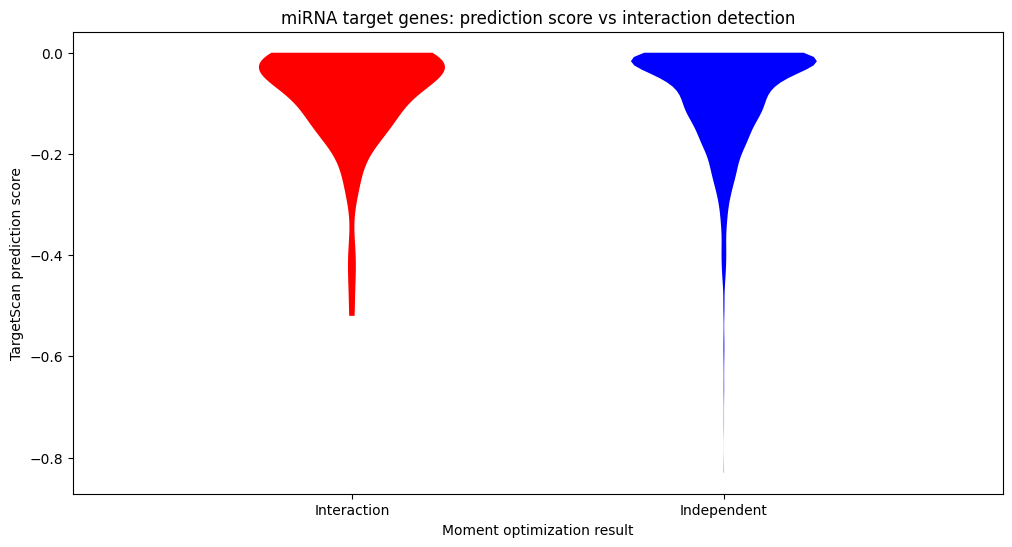

In [291]:
df = df_2.iloc[pcRNA_indices]
df = df[df['Target'] == True]
pos = df[df['Interaction'] == True]['Score'].to_list()
neg = df[df['Interaction'] == False]['Score'].to_list()

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan prediction score")
axs.set_title("miRNA target genes: prediction score vs interaction detection")

In [253]:
tg = result_df[result_df['Target'] == True]['Interaction']
ntg = result_df[result_df['Target'] == False]['Interaction']

print(f"Target genes have {tg.mean() * 100}% interaction detected")
print(f"Non-Target genes have {ntg.mean() * 100}% interaction detected")

Target genes have 0.46312789454934095% interaction detected
Non-Target genes have 0.5937981086430614% interaction detected


In [254]:
# restricting to protein coding genes (at least those known protein coding from API lookup)
tg_pc = result_df.iloc[pcRNA_indices]
ntg_pc = result_df.iloc[pcRNA_indices]
tg = tg_pc[tg_pc['Target'] == True]['Interaction']
ntg = ntg_pc[ntg_pc['Target'] == False]['Interaction']

print(f"(Protein coding) Target genes have {tg.mean() * 100}% interaction detected")
print(f"(Protein coding) Non-Target genes have {ntg.mean() * 100}% interaction detected")

(Protein coding) Target genes have 0.4543733434305188% interaction detected
(Protein coding) Non-Target genes have 0.623608017817372% interaction detected


Text(0.5, 0, 'Prediction score')

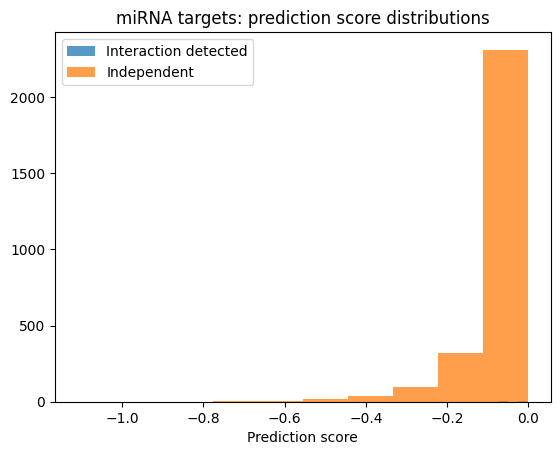

In [255]:
plt.hist(pos, label="Interaction detected", alpha=0.75)
plt.hist(neg, label="Independent", alpha=0.75)
plt.legend()
plt.title("miRNA targets: prediction score distributions")
plt.xlabel("Prediction score")

## Storing results

In [256]:
result_df.to_csv("Results/TargetScan8.0__miR-16-2-3p_195-3p.Human.predicted_targets.csv")

In [209]:
# pd.read_csv("Results/TargetScan8.0__miR-99-5p_100-5p.Human.predicted_targets.csv",index_col=0)

# Include mean expression < 1 genes

In [403]:
# read fibroblast transcript counts (for genes with mean expression > 0)
data_all_FIB = pd.read_csv("../Datasets/GSE151334_FIB_counts_cleaned.csv", index_col=0)

In [404]:
beta_all = estimate_capture(data_all_FIB)

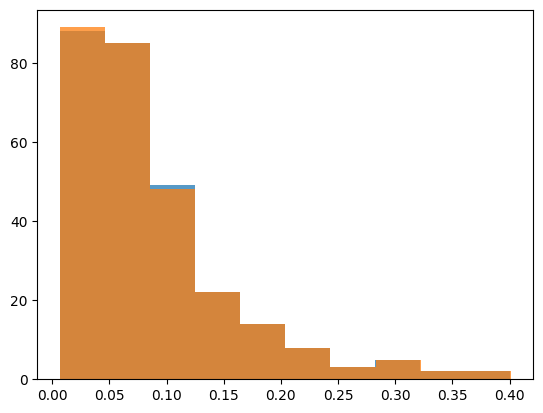

In [405]:
plt.hist(beta, alpha=0.75);
plt.hist(beta_all, alpha=0.75);

In [406]:
# set miRNA
mir = 1 #2
i = 0

# load predicted targets
target_df = pd.read_csv(target_files[mir][i], delimiter="\t", index_col=0)

# display statistics
target_names = list(target_df.index)
gene_names = list(data_all_FIB.index)
gene_names_thresh = list(data_FIB.index)
shared_names = list(set(target_names) & set(gene_names))
shared_names_thresh = list(set(target_names) & set(gene_names_thresh))

print(f"{len(target_names)} miRNA targets predicted")
print(f"{len(shared_names)} are in the dataset (mean expr > 0)")
print(f"{len(shared_names_thresh)} are in the dataset (mean expr > 1)")

4756 miRNA targets predicted
4419 are in the dataset (mean expr > 0)
2770 are in the dataset (mean expr > 1)


In [407]:
# construct dataset of the miRNA paired with all other samples
dataset_mir = construct_dataset("test", data_miRNA.iloc[mir], data_all_FIB, beta)

In [408]:
# bootstrap moments
dataset_mir.compute_moments(tqdm_disable=False)

100%|██████████| 34800/34800 [24:28<00:00, 23.70it/s] 


In [409]:
# moment optimization test
moment_mir = optimization.Optimization(
    dataset_mir,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file=None
)

100%|██████████| 34800/34800 [02:55<00:00, 197.74it/s]


In [410]:
result_dict = {}

E_beta = np.mean(beta)
E_beta_sq = np.mean(beta**2)

for i, moment_dict in enumerate(dataset_mir.moments_OB.values()):
    x = moment_dict['E_x1']
    y = moment_dict['E_x2']
    z = moment_dict['E_x1_x2']

    lb = (x[0] / E_beta) * (y[0] / E_beta)
    ub = (x[1] / E_beta) * (y[1] / E_beta)

    # xy interval below z interval
    if (lb < (z[0] / E_beta_sq)) and (ub < (z[0] / E_beta_sq)):
        result_dict[i] = {'status': "INFEASIBLE"}
    # xy interval above z interval
    elif (lb > (z[1] / E_beta_sq)) and (ub > (z[1] / E_beta_sq)):
        result_dict[i] = {'status': "INFEASIBLE"}
    # xy interval overlaps with z interval
    else:
        result_dict[i] = {'status': "OPTIMAL"}

In [411]:
[res['status'] for res in moment_mir.result_dict.values()] == [res['status'] for res in result_dict.values()]

True

In [412]:
# create result dataframe
result_df = pd.DataFrame(
    index = data_all_FIB.index,
    columns = ['Target', 'Score', 'Interaction']
)

# enter results
for i, result in moment_mir.result_dict.items(): #result_dict.items():

    # get gene name
    name = gene_names[i]

    # if miRNA target: get prediction score
    if name in target_names:
        target = True
        score = target_df.loc[name]['Cumulative weighted context++ score']
    else:
        target = False
        score = None

    # get interaction prediction
    if result['status'] == "INFEASIBLE":
        interaction = True
    else:
        interaction = False

    result_df.iloc[i] = [target, score, interaction]

Text(0.5, 1.0, 'miRNA target genes: prediction score vs interaction detection')

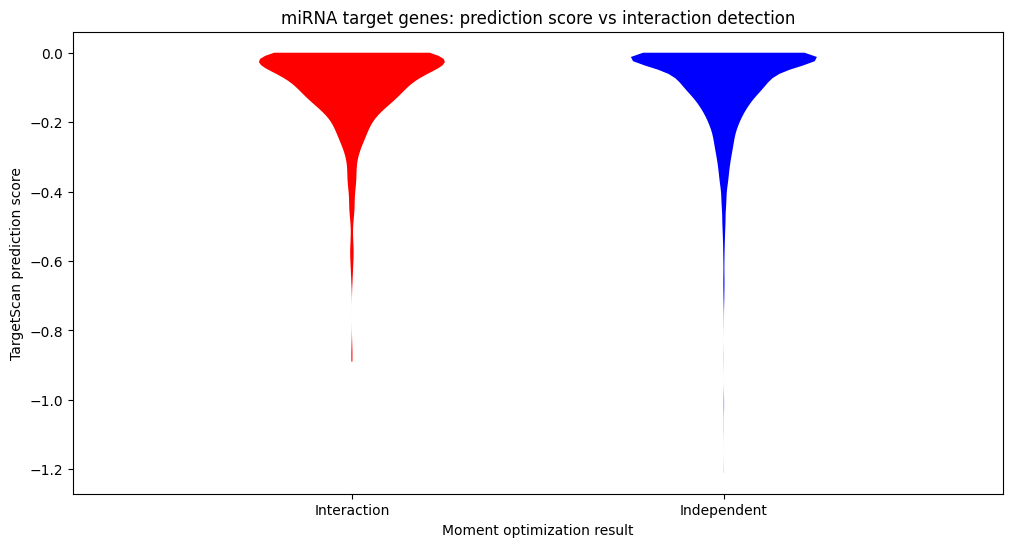

In [413]:
df = result_df[result_df['Target'] == True]
pos = df[df['Interaction'] == True]['Score'].to_list()
neg = df[df['Interaction'] == False]['Score'].to_list()

pos = [float(x) for x in pos if type(x) == np.float64]
neg = [float(y) for y in neg if type(y) == np.float64]

fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        pos,
        neg
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("TargetScan prediction score")
axs.set_title("miRNA target genes: prediction score vs interaction detection")

In [414]:
tg = result_df[result_df['Target'] == True]['Interaction']
ntg = result_df[result_df['Target'] == False]['Interaction']

print(f"Target genes have {tg.mean() * 100}% interaction detected")
print(f"Non-Target genes have {ntg.mean() * 100}% interaction detected")

Target genes have 14.980764878931884% interaction detected
Non-Target genes have 13.992297817715018% interaction detected


Text(0.5, 1.0, 'miRNA target genes: mean expression vs interaction detection')

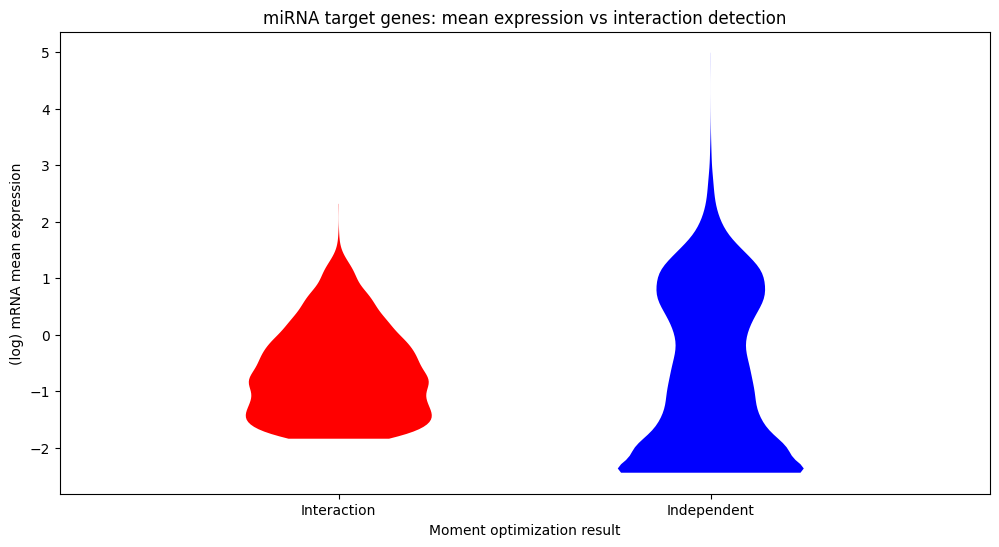

In [415]:
# separate by interaction / independent result
int_df = result_df[result_df['Interaction'] == True]
ind_df = result_df[result_df['Interaction'] == False]

# lookup samples
int_sample_df = data_all_FIB.loc[int_df.index]
ind_sample_df = data_all_FIB.loc[ind_df.index]

# compute means
int_means = np.log10(int_sample_df.mean(axis=1).to_list())
ind_means = np.log10(ind_sample_df.mean(axis=1).to_list())

# plot
fig, axs = plt.subplots(figsize=(12, 6))
vp = axs.violinplot(
    [
        int_means,
        ind_means
    ],
    showextrema=False
)
colours = ["red", "blue"]
for i, vi in enumerate(vp['bodies']):
    vi.set_facecolor(colours[i])
    vi.set_edgecolor(None)
    vi.set_alpha(1)
labels = ["Interaction", "Independent"]
axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
axs.set_xlim(0.25, len(labels) + 0.75)
axs.set_xlabel('Moment optimization result')
axs.set_ylabel("(log) mRNA mean expression")
axs.set_title("miRNA target genes: mean expression vs interaction detection")